# Analyzing maizsim output - baseline control simulation
- Main task: 
    - Analyze the first batch of baseline simulations (historic met + uniform cultivar)
    - Compare simulated yield with historic yield
- Main input: 
    - baseline simulation outputs
    - USDA NASS historic maize yield data
    - historic met data
- Main output: 
    - simulated yield map
    - simulated vs. actual yield
    - yield climate sensitivity

In [18]:
# this loads previoulsy stored environment
import dill
dill.load_session('sim_con_env.db')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime
import seaborn as sns
import os

from scipy.stats.stats import pearsonr
from palettable.colorbrewer.sequential import OrRd_6
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import YlGnBu_8
from palettable.colorbrewer.sequential import RdPu_5

### Step 1. Load in all simulation outputs
- Main input:
    - /sims/**con/out1/***
- Main output: **df_fsims** (fsims = filtered simulations)

#### 1.1. File reading prep

In [3]:
files = glob.glob('/home/disk/eos8/ach315/upscale/sims/con/out1/*')
print('total simulated site-years:', len(files))

# manual update of maizsim output column name
cols = ['year', 'site', 'date', 'jday', 'time', 
        'leaves', 'mature_lvs', 'drop_lvs', 'LA', 'LA_dead', 'LAI', 
        'RH', 'leaf_WP', 'PFD', 'solrad', 'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply',
        'Pn', 'Pg', 'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded', 
        'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit', 'gs_shaded', 'VPD',
        'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total', 'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 
        'df_stem', 'df_root', 'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note']

total simulated site-years: 1920


#### 1.2 Fetching final simulation point

In [4]:
%%time 

data_all = []
issues = []

for file in files:
    year = file.split('/')[-1].split('_')[-1].split('.')[-2]
    site = file.split('/')[-1].split('_')[-2]
   
    with open(file, 'r') as f:
        f.seek(0, os.SEEK_END) # moving the pointer to the very end of the file
                               # * f.seek(offset, whence)
                               # * The position is computed from adding offset to a reference point,
                               # * the reference point is selected by the whence argument.
                               # * os.SEEK_SET (=0)
                               # * os.SEEK_CUR (=1)
                               # * os.SEEK_END (=2)
        f.seek(f.tell() - 3000, os.SEEK_SET) # finding the current position (which should be at the very end of the file)
                                             # and counting back a few positions 
                                             # and reading forward from there
                                             # * f.tell() returns an integer giving the file object’s 
                                             # * current position in the file represented as number of bytes 
                                             # * from the beginning of the file when in binary mode 
                                             # * and an opaque number when in text mode.

        for line in f:
            f_content = f.readlines()
            
        if len(f_content[-1]) == 523: # character length of a normal output
            sim_output = list(f_content[-1].split(','))
            data = [i.strip() for i in sim_output]
            data.insert(0, year)
            data.insert(1, site)
            data_all.append(data)

        else: 
            issues.append(file) # these are simulations with outburst of weird outputs 

df_sims = pd.DataFrame(data_all, columns=cols)
df_sims.dm_total = df_sims.dm_total.astype(float)
df_sims.dm_ear = df_sims.dm_ear.astype(float)

CPU times: user 423 ms, sys: 208 ms, total: 631 ms
Wall time: 17.3 s


In [5]:
df_sims.head()

,year,site,date,jday,time,leaves,mature_lvs,drop_lvs,LA,LA_dead,...,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c,note
0,1964,03103,09/06/1964,23626,5,15.00,15,12,172.34,3291.69,...,53.39,5.36,3.57,11.78,26.367,26.377,0.0,0.000,0.00,"""Matured"""
1,1973,03812,08/03/1973,26879,11,15.00,15,12,160.68,3127.94,...,87.67,11.43,7.51,30.42,44.164,44.186,0.0,0.000,0.27,"""Matured"""
2,1975,03812,07/31/1975,27606,14,15.00,15,12,165.95,3153.30,...,99.10,10.83,7.13,32.24,47.257,47.268,0.0,0.000,0.48,"""Matured"""
3,1979,03812,07/31/1979,29067,15,15.00,15,12,159.55,3069.20,...,97.84,10.69,7.02,35.72,44.308,44.326,0.0,0.000,0.58,"""Matured"""
4,1980,03812,07/20/1980,29422,14,15.00,15,12,162.98,3158.05,...,51.01,10.59,6.97,31.57,47.205,47.237,0.0,0.000,0.56,"""Matured"""


In [12]:
df_sims.groupby('note').count()

,year,site,date,jday,time,leaves,mature_lvs,drop_lvs,LA,LA_dead,...,dm_shoot,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c
note,,,,,,,,,,,,,,,,,,,,,
"""Emerged""",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"""Germinated""",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"""Matured""",1811,1811,1811,1811,1811,1811,1811,1811,1811,1811,...,1811,1811,1811,1811,1811,1811,1811,1811,1811,1811
"""Silked""",14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
"""Tasseled""",7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
"""Tasselinit""",13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
"""grainFill""",6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


#### 1.3 Filter out irrigated and/or low planting sites
check **sites_filter.ipynb** for site filtering detail

In [431]:
df_fsites = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/sites_filtered.csv', 
                        index_col=0, dtype={'site': object}) 
df_fsites.head()

,site,years,city,state,lat,lon,area,perct_irri
3,03820,19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
5,03856,27,HUNTSVILLE,AL,34.39,86.46,64051.0,1.439798
8,03927,10,FORT WORTH,TX,32.50,97.03,109765.0,1.894422
9,03928,18,WICHITA,KS,37.39,97.25,371614.4,3.770120
12,03945,15,COLUMBIA,MO,38.49,92.13,103435.6,2.651787


In [432]:
df_fsims = pd.merge(df_sims, df_fsites, on='site')

In [387]:
print('site-years before filtering:', df_sims.shape[0])
print('site-years after filtering:', df_fsims.shape[0])

site-years before filtering: 1853
site-years after filtering: 813


In [9]:
# *** JH200515 - updated how I want to read in data,
# but keeping this for now since there seems to be some suspicious files 

# - For some weird reason, quite a few sim outputs don't have headers.
# - I wonder if this has anything to do with the files that I overwrote when moving them into the separate folders.
# - maybe these are runs that got cut off at the 6hrs wall time, and had to be resubmitted so had truncated sim outputs?
# - not sure, haven't checked yet, just a guess

dm_ears = list()
sites = list()
years = list()

for file in files:
    site = file.split('/')[-1].split('_')[-2]
    year = file.split('/')[-1].split('_')[-1].split('.')[-2]
    try:
        df = pd.read_csv(file)
        df.columns = cols
        ear = df.dm_ear.max()
        dm_ears.append(ear)
        sites.append(site)
        years.append(year)
    except:
        print(file)
        df = pd.read_csv(file, header=None, index_col=[0])
        df.columns = cols
        ear = df.dm_ear.max()
        dm_ears.append(ear)
        sites.append(site)
        years.append(year)


/home/disk/eos8/ach315/upscale/sims/con/out1/out1_13958_1983.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_13959_1982.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_14737_1981.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_24233_1979.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_93721_1980.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_94814_1974.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_94822_1975.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_03820_1985.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_03856_1986.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_03860_1984.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_03937_1987.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_14768_1983.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_14820_1982.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_14913_1981.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_94846_1979.txt
/home/disk/eos8/ach315/up

### Step 3. Plotting out yield maps

#### 3.1 Simulated output for individual years

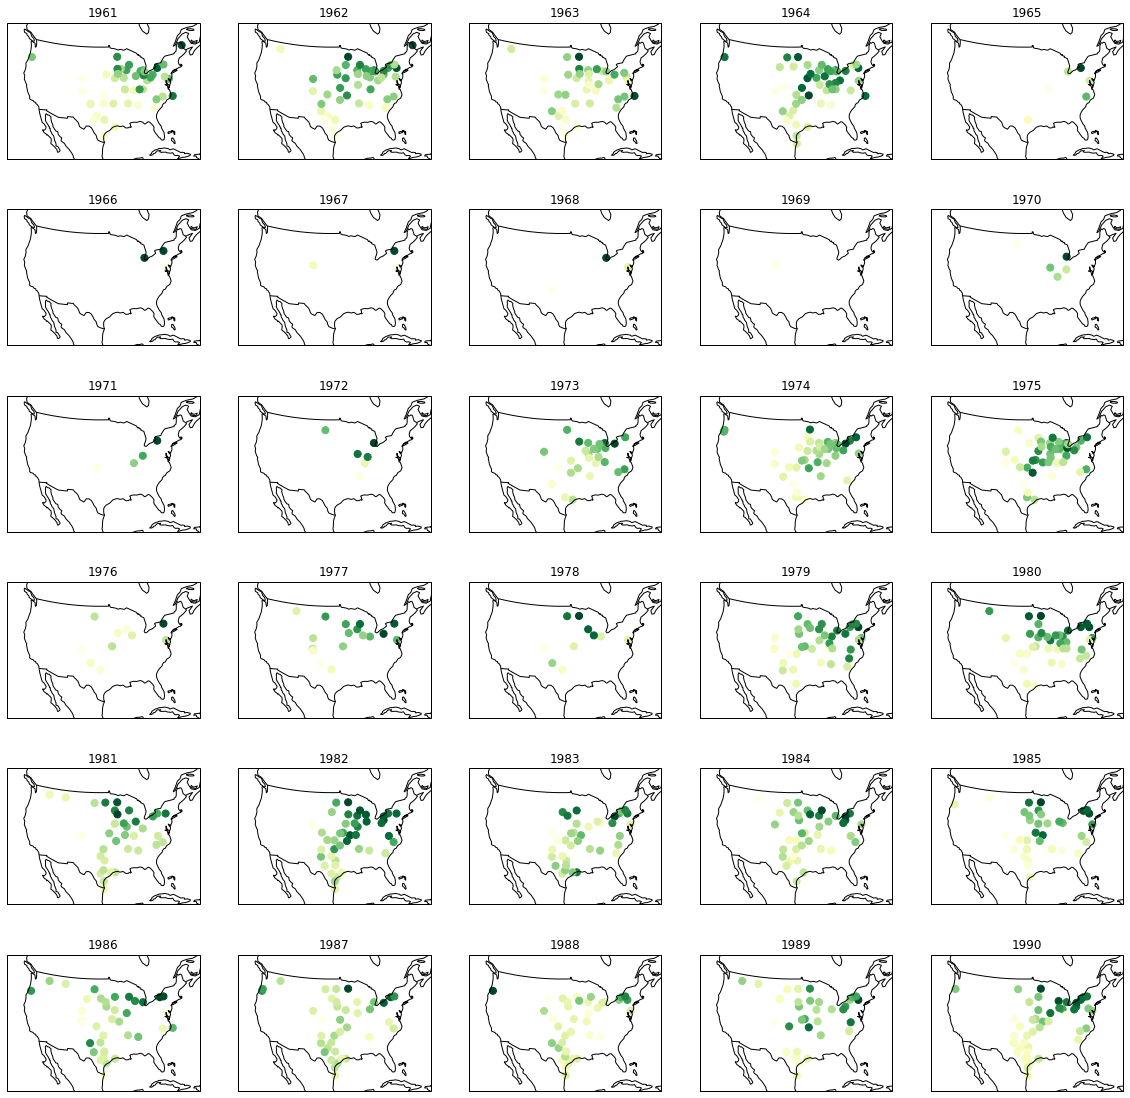

In [434]:
years = np.arange(1961, 1991)
extent = [-123, -72, 19, 53]

fig, axs = plt.subplots(6, 5, figsize=(20,20), 
                        subplot_kw={'projection': ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35)})

for ax, year in zip(axs.flatten(), years):
    df_sub = df_fsims[df_fsims.year == str(year)]
    ax.scatter(df_sub.lon.astype(float)*-1, df_sub.lat.astype(float), 
               c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap,
               transform=ccrs.PlateCarree(), alpha=1, s=50) # what does 'transform' do, and why does it not work when 
                                                            # I use 'AlbersEqualArea'?
    ax.set_extent(extent)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.set(title=year)    

#### 3.2 Average yield for each location

In [435]:
df_fsims_sitesum = df_fsims.groupby('site').mean()
df_fsims_sitesum.head()

,dm_total,dm_ear,years,lat,lon,area,perct_irri
site,,,,,,,
03820,101.802000,27.788889,19,33.22,81.58,53057.0,18.731754
03856,94.847538,25.985385,27,34.39,86.46,64051.0,1.439798
03927,102.347833,24.580000,10,32.50,97.03,109765.0,1.894422
03928,111.602273,31.646364,18,37.39,97.25,371614.4,3.770120
03945,148.330143,58.262857,15,38.49,92.13,103435.6,2.651787


Text(0, 0.5, 'mean simulated yield (g/plant)')

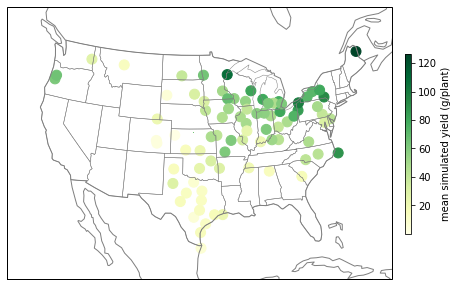

In [443]:
from palettable.colorbrewer.sequential import YlGn_9

fig = plt.figure(figsize=(8,5))
extent = [-123, -72, 19, 53]
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df_fsims_sitesum.lon.astype(float)*-1, df_fsims_sitesum.lat.astype(float), 
           transform=ccrs.PlateCarree(), 
           s=100, c=df_fsims_sitesum.dm_ear, cmap=YlGn_9.mpl_colormap)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)


# weird way to brute force add color bar scale - there might be a better way
lim = np.array([[df_sitesum.ear.min(), df_sitesum.ear.max()]])
im1 = plt.imshow(lim, cmap=YlGn_9.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.87, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('mean simulated yield (g/plant)')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/mean_yield.png', format='png', dpi=800)

#### 3.3 Scaling up and comparing with historical yield data

g/plant -> tons/ha <br/>
assume planting density of 10 plants/m2 <br/>
1 ha = 10,000 m2 <br/> 
1 ton = 907185 g <br/>

example case: <br/>
50 g/plant = 50 x 10 g/m2 (10 plants/m2) <br/>
50 x 10000 g/ha (scaling up from m2 to ha) <br/>
(50 x 10000 x 0.86) / 907185 ton/ha <br/>
0.86: conversion from ear to grain biomass

(50 x 10 x 10000 x 0.86)/907185 = ~ 4.7 tons/ha yield

Text(0, 0.5, 'mean simulated yield (tons/ha)')

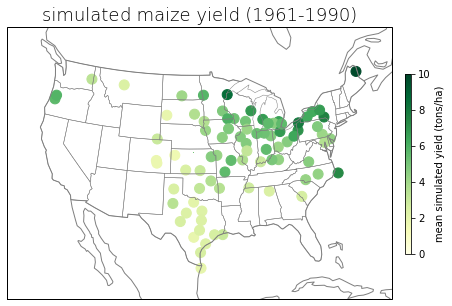

In [441]:
from palettable.colorbrewer.sequential import YlGn_9

fig = plt.figure(figsize=(8,5))
extent = [-123, -72, 19, 53]
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df_fsims_sitesum.lon.astype(float)*-1, df_fsims_sitesum.lat.astype(float), 
           transform=ccrs.PlateCarree(), 
           s=100, c=(df_fsims_sitesum.dm_ear*10*10000*0.86)/907185 , vmin=0, vmax=10,
           cmap=YlGn_9.mpl_colormap)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('simulated maize yield (1961-1990)', 
              fontweight='light', fontsize=18)

# weird way to brute force add color bar scale - there might be a better way
lim = np.array([[0,10]])
im1 = plt.imshow(lim, cmap=YlGn_9.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.87, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('mean simulated yield (tons/ha)')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/mean_yield_tonsperha.png', format='png', dpi=800)

### Step 4. Comparison with historic yield

#### Step 4.1. Read in USDA NASS data & subsetting for year 1961-1990
- Main input: /data/**NASS_cropdata**
    - stateID
    - countyID
    - lat_county
    - lon_county
    - corn_yield
    - corn_area
- Main output: **df_hyield_sitemean** (hyield = historic yield)
    - will be used to compare historic yield vs. simulated control - uniform cultivar (baseline) yield

In [482]:
%%time 

# Reading in state & county id
state_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/stateID.txt", sep="\s+", header=None)
state_id = state_id.transpose()
state_id.columns = ["state_id"]
county_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/countyID.txt", sep="\s+", header=None)
county_id = county_id.transpose()
county_id.columns = ["county_id"]

# Reading in lat & lon information
lat_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lat_county.txt", sep="\s+", header=None)
lat_county = lat_county.transpose()
lat_county.columns = ["lat"]
lon_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lon_county.txt", sep="\s+", header=None)
lon_county = lon_county.transpose()
lon_county.columns = ["lon"]

# Reading in maize yield
cornyield = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_yield.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornyield.columns = years

# Reading in maize area
cornarea = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_area.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornarea.columns = years
cornarea = cornarea.melt(var_name='year', value_name='area')
cornarea = cornarea.drop(['year'], axis=1)

# concatinating all information and melting dataframe
df = pd.concat([state_id, county_id, lat_county, lon_county, cornyield], axis=1)
df = pd.melt(df, id_vars=['state_id', 'county_id', 'lat', 'lon'], value_name='yield', var_name="year")
df = pd.concat([df, cornarea], axis=1)

# selecting only years 1961-1990
df_hyield = pd.DataFrame()
years = np.arange(1961,1991)

for i in range(len(years)):
    data = df[df['year'] == years[i]]
    df_hyield = pd.concat([df_hyield, data])

df_hyield = df_hyield.dropna()
    
# calculating mean yield & area planted across 1961-1990
df_hyield_sitemean = df_hyield.groupby(['state_id', 'county_id']).mean()
df_hyield_sitemean = df_hyield_sitemean.reset_index()

CPU times: user 4.6 s, sys: 258 ms, total: 4.86 s
Wall time: 4.85 s


#### 4.2 Filtering out sites with irrigation and/or low planting area

In [485]:
df_hyield_sitemean.head()

,state_id,county_id,lat,lon,yield,area
0,1.0,1.0,32.462991,-86.709691,2.462788,2956.233183
1,1.0,3.0,30.787262,-87.712913,4.256056,9584.319770
2,1.0,5.0,31.870087,-85.383129,2.689588,5805.224477
3,1.0,7.0,33.072877,-87.112698,2.303269,913.049299
4,1.0,9.0,33.988350,-86.613622,3.113897,3230.340665


#### 4.3 Distance calculation
linking weather stations with 5 nearest historic yield observation sites

*** 200515 need to think about how to exclude irrigated sites for historic yield

#### 4.3. visualization
note: historic yield & simulated yield have now been converted to same units

ValueError: 'c' argument has 77 elements, which is inconsistent with 'x' and 'y' with size 84.

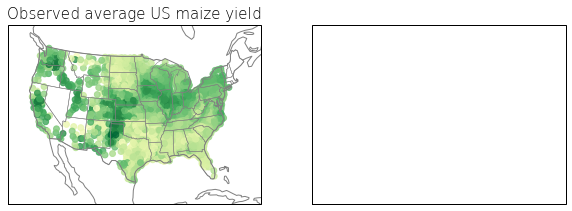

In [486]:
fig = plt.figure(figsize=(10,5))

# plotting temperature
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])

ax1.scatter(df_hyield_sitemean['lon'], df_hyield_sitemean['lat'], transform=ccrs.PlateCarree(), 
           c=df_hyield_sitemean['yield'], vmin=0, vmax=10, s=35, 
           cmap=YlGn_9.mpl_colormap, alpha=0.8)

ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Observed average US maize yield', fontweight='light', fontsize=15)


# plotting precip
ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-123, -72, 19, 53])
ax2.scatter(df_fsims_sitesum.lon.astype(float)*-1, df_fsims_sitesum.lat.astype(float), 
            transform=ccrs.PlateCarree(), 
            s=35, c=(df_highsimarea.ear*10*10000*0.86)/907185 , vmin=0, vmax=10,
            cmap=YlGn_9.mpl_colormap)

ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Simulated average US maize yield', 
              fontweight='light', fontsize=15)

# adding colorbar
lim = np.array([[0,10]])
im1 = plt.imshow(lim, cmap=YlGn_9.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.91, 0.295, 0.01, 0.41]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('yield (tons/ha)')

# margin adjustments
fig.subplots_adjust(left=0.02, bottom=0, right=0.9, top=1, 
                    hspace=0.02, wspace=0.05)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/yieldmap_obsandsim.png', format='png', dpi=800)

### Step 5. Baseline climatology & climate sensitivity in simulations
**** JH 200507- code still in progress ****

#### - Reading in all weather data and putting together xarray dataset

In [57]:
# reading in weather data
df_temp = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_all.csv', index_col= 0)
df_rh = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_all.csv', index_col= 0)
df_precip = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_all.csv', index_col= 0)
df_solrad = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/backup/solrad_all.csv', index_col= 0)
df_solrad = df_solrad.reindex(df_temp.index)

In [45]:
# listing sites to drop from dataset
df_siteinfo = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_info.csv", index_col=0, dtype=str)
sites_AK = df_siteinfo[df_siteinfo.state == 'AK'].site # excluding Alaska
sites_HI = df_siteinfo[df_siteinfo.state == 'HI'].site # excluding Hawaii
sites_PI = df_siteinfo[df_siteinfo.state == 'PI'].site # excluding Guam
drop_sites = list(sites_AK.append(sites_HI).append(sites_PI))

In [46]:
# reforming dataframes
df_temp = df_temp.drop(drop_sites, axis=1)
df_rh = df_rh.drop(drop_sites, axis=1)
df_precip = df_precip.drop(drop_sites, axis=1)
df_solrad = df_solrad.drop(drop_sites, axis=1)
df_siteinfo = df_siteinfo[df_siteinfo.state != 'AK'] # excluding Alaska
df_siteinfo = df_siteinfo[df_siteinfo.state != 'HI'] # excluding Hawaii
df_siteinfo = df_siteinfo[df_siteinfo.state != 'PI'] # excluding GUAM

In [47]:
# putting together xr.Dataset
timepoints = pd.to_datetime(df_temp.index)
sites = df_temp.columns

ds_wea = xr.Dataset({'temp': (['time', 'site'], df_temp),
                     'precip': (['time', 'site'], df_precip),
                     'rh': (['time', 'site'], df_rh),
                     'solrad': (['time', 'site'], df_solrad)},
                    coords= {'time': timepoints, 
                             'site': sites,
                             'lat': df_siteinfo.lat.astype(float), 
                             'lon': df_siteinfo.lon.astype(float)})

ds_wea

<xarray.Dataset>
Dimensions:  (dim_0: 215, site: 215, time: 197310)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) datetime64[ns] 1961-03-01 1961-03-01T01:00:00 ...
  * site     (site) object '03103' '03812' '03813' '03820' '03822' '03856' ...
    lat      (dim_0) float64 35.08 35.26 32.42 33.22 32.08 34.39 38.22 34.54 ...
    lon      (dim_0) float64 111.4 82.32 83.39 81.58 81.12 86.46 82.33 82.13 ...
Data variables:
    temp     (time, site) float64 nan 12.2 21.7 21.1 18.9 12.8 nan nan 12.2 ...
    precip   (time, site) float64 nan nan 0.0 0.0 0.0 0.0 nan nan nan 0.0 ...
    rh       (time, site) float64 nan 61.14 60.67 67.7 96.25 71.35 nan nan ...
    solrad   (time, site) float64 nan 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [160]:
# gathering weather data from all site-years and putting into xarray
years = np.arange(1961,1991)
cols = ['year', 'precip', 'temp', 'rh', 'site', 'lat', 'lon']
df_wea = pd.DataFrame(columns = cols)

for i in years:
    df_year = pd.DataFrame({'year': str(i),
                            'precip': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).precip.sum(dim='time'),
                            'temp': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).temp.mean(dim='time'),
                            'rh': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).rh.mean(dim='time'),
                            'site': ds_wea.site, 'lat': ds_wea.lat, 'lon': ds_wea.lon})
    df_wea = pd.concat([df_wea, df_year])

df_wea = df_wea.drop(['lat', 'lon'], axis=1)

In [164]:
# creating master summary dataframe
df_summary = pd.merge(df_earsum, df_wea, how='left', on=['site', 'year'])
df_summary = df_summary[df_summary.rh<100] # there are so many sites with RH > 100, so I'm taking it out for the moment
                                           # 200210JH: need to look into this issue   
                                           # there initially were site-years with really high precip levels as well
                                           # but those were eventually dropped when excluding AK, HI, and Guam

# including vpd information
def CC(temp, RH):
    Es_TRef = 6.11 # Es at reference temperature = 6.11 (mb)
    TRef    = 273.15 # reference temperature (K)
    Lv      = 2.5e+06 # evaporization latent heat = 2.5*10e6 (J/kg)
    Rv      = 461 # gas constant = 461 (J/K*kg)
    
    Es = Es_TRef*np.exp((Lv/Rv)*(1/TRef-1/(temp+TRef)))
    E = (Es*RH)/100
    VPD = Es-E # units mb
    VPD = VPD/10 # converting mb into kPa (1mb = 0.1kPa)
    
    return(VPD)

df_summary['vpd'] = CC(df_summary.temp, df_summary.rh)

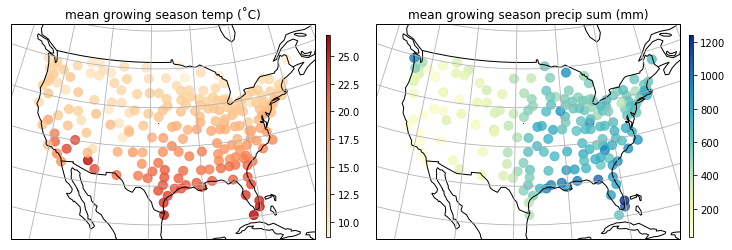

In [166]:
# plotting out baseline climatology for temp & precip
fig = plt.figure(figsize=(12,8))

# plotting temperature
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-130, -60, 10, 48])
ax1.scatter(ds_wea.lon.astype(float)*-1, ds_wea.lat.astype(float), 
            transform=ccrs.PlateCarree(), c= ds_wea.mean('time').temp, s=80,
            cmap=OrRd_6.mpl_colormap, alpha= 0.8)

ax1.set_extent(extent)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
ax1.gridlines()
ax1.set_title('mean growing season temp (˚C)')

lim = np.array([[ds_wea.mean('time').temp.min(), ds_wea.mean('time').temp.max()]])
im1 = plt.imshow(lim, cmap=OrRd_6.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.49, 0.32, 0.005, 0.35])
cb1 = plt.colorbar(im1, cax=cb_ax1)

# summarizing precipition info across site and years
df_precip_summ = pd.DataFrame(df_summary.groupby('site').precip.mean()).reset_index()
df_precip_summ = pd.merge(df_precip_summ, df_siteyears, how='left', on=['site'])

# plotting precip
ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-130, -60, 10, 48])
ax2.scatter(df_precip_summ.lon.astype(float)*-1, df_precip_summ.lat.astype(float), 
            transform=ccrs.PlateCarree(), c= df_precip_summ.precip, s=80,
            cmap=YlGnBu_8.mpl_colormap, alpha= 0.8)

ax2.set_extent(extent)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)
ax2.gridlines()
ax2.set_title('mean growing season precip sum (mm)')

lim = np.array([[df_precip_summ.precip.min(), 
                 df_precip_summ.precip.max()]])
im2 = plt.imshow(lim, cmap=YlGnBu_8.mpl_colormap)
im2.set_visible("False")
cb_ax2 = fig.add_axes([0.91, 0.32, 0.005, 0.35])  
cb2 = plt.colorbar(im2, cax=cb_ax2)

### 6. Yield sensitivity to climate factors

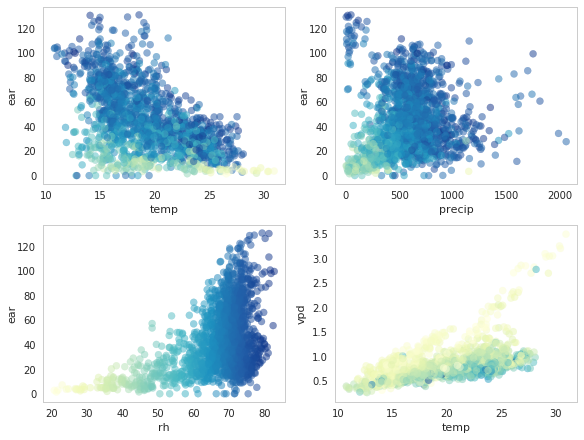

In [204]:
# yield responses to climate factors

fig, axs = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
axs = axs.flatten()
axs[0].scatter(df_summary.temp, df_summary.ear, alpha=0.5, c=df_summary.rh, cmap=YlGnBu_8.mpl_colormap)
axs[0].set_xlabel('temp'); axs[0].set_ylabel('ear', labelpad=0)
axs[1].scatter(df_summary.precip, df_summary.ear, alpha=0.5, c=df_summary.rh, cmap=YlGnBu_8.mpl_colormap)
axs[1].set_xlabel('precip'); axs[1].set_ylabel('ear', labelpad=0)
axs[2].scatter(df_summary.rh, df_summary.ear, alpha=0.5, c=df_summary.rh, cmap=YlGnBu_8.mpl_colormap)
axs[2].set_xlabel('rh'); axs[2].set_ylabel('ear', labelpad=0)
axs[3].scatter(df_summary.temp, df_summary.vpd, alpha=0.5, c=df_summary.precip, cmap=YlGnBu_8.mpl_colormap)
axs[3].set_xlabel('temp'); axs[3].set_ylabel('vpd', labelpad=5)
plt.savefig('/home/disk/eos8/ach315/upscale/figs/wea_yield.png')

In [227]:
df_summary.head()

,ear,site,year,years,city,state,lat,lon,precip,temp,rh,vpd,ear_diff,temp_diff,precip_diff,rh_diff
3,99.10,03812,1975,20,ASHEVILLE,NC,35.26,82.32,1750.2,17.913493,80.071098,0.413221,23.86,-0.052759,954.975,2.829528
4,97.84,03812,1979,20,ASHEVILLE,NC,35.26,82.32,791.1,18.049854,81.851357,0.379605,22.60,0.083602,-4.125,4.609788
7,86.80,03812,1982,20,ASHEVILLE,NC,35.26,82.32,617.6,17.988220,80.312714,0.410168,11.56,0.021968,-177.625,3.071144
8,70.20,03812,1983,20,ASHEVILLE,NC,35.26,82.32,628.7,18.176417,75.849098,0.509255,-5.04,0.210165,-166.525,-1.392471
9,71.69,03812,1985,20,ASHEVILLE,NC,35.26,82.32,555.7,17.986991,76.229819,0.495193,-3.55,0.020739,-239.525,-1.011751


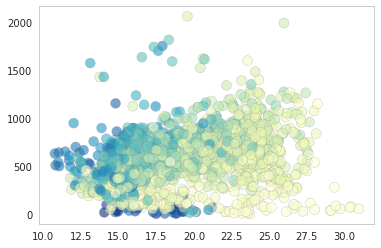

In [274]:
plt.scatter(df_summary.temp, df_summary.precip, c=df_summary.ear, 
            cmap=YlGnBu_8.mpl_colormap, alpha=0.6, edgecolors='grey', s=100)

In [515]:
temps = np.arange(df_summary.temp.min(), df_summary.temp.max(), 1)
precips = np.arange(df_summary.precip.max(), df_summary.precip.min(), -95)
#precips = np.arange(df_summary.precip.min(), df_summary.precip.max(), 95)
mapmatrix = np.zeros((len(temps), len(precips)))
mapmatrix.shape

(21, 22)

In [516]:
temps

array([10.78364167, 11.78364167, 12.78364167, 13.78364167, 14.78364167,
       15.78364167, 16.78364167, 17.78364167, 18.78364167, 19.78364167,
       20.78364167, 21.78364167, 22.78364167, 23.78364167, 24.78364167,
       25.78364167, 26.78364167, 27.78364167, 28.78364167, 29.78364167,
       30.78364167])

In [520]:
precips

array([2059.6, 1964.6, 1869.6, 1774.6, 1679.6, 1584.6, 1489.6, 1394.6,
       1299.6, 1204.6, 1109.6, 1014.6,  919.6,  824.6,  729.6,  634.6,
        539.6,  444.6,  349.6,  254.6,  159.6,   64.6])

In [100]:
# temp vs. vpd
temps = np.arange(df_summary.temp.min(), df_summary.temp.max(), 1)
vpds = np.arange(df_summary.vpd.max(), df_summary.vpd.min(), -0.15)
mapmatrix = np.zeros((len(temps), len(vpd)))
print(mapmatrix.shape)

for i in np.arange(len(temps)-1):
    df_t = df_summary[(df_summary.temp > temps[i]) & (df_summary.temp < temps[i+1])]
    
    for j in np.arange(len(vpd)-1):
        df_p = df_t[(df_t.vpd < vpds[j]) &  (df_t.vpd > vpds[j+1])]
        mapmatrix[j,i] = df_p.ear.mean()

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots()
    ax = sns.heatmap(mapmatrix, cmap='YlGn')
    plt.colorbar(im)
    ax.set_xticks(np.arange(0, len(temps), 5))
    ax.set_yticks(np.arange(0, len(vpds), 3))
    ax.set_xticklabels(np.round(temps,2)[np.arange(0, len(temps), 3)])
    ax.set_yticklabels(np.round(vpds,2)[np.arange(0, len(vpds), 3)])
    ax.set_xlabel('temperature (˚C)')
    ax.set_ylabel('vpd (kPa)')

(21, 1561)


IndexError: index 22 is out of bounds for axis 0 with size 22

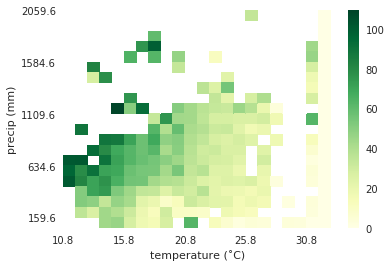

In [561]:
for i in np.arange(len(temps)-1):
    df_t = df_summary[(df_summary.temp > temps[i]) & (df_summary.temp < temps[i+1])]
    
    for j in np.arange(len(precips)-1):
        df_p = df_t[(df_t.precip < precips[j]) &  (df_t.precip > precips[j+1])]
        mapmatrix[j,i] = df_p.ear.mean() # i & j are flipped since
                                         # i: temp group - column
                                         # j: precip group - row
                                         # matrix structure: row x column
    
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots()
    ax = sns.heatmap(mapmatrix, cmap='YlGn')                                                      
    ax.set_xticks(np.arange(0, len(temps), 5))
    ax.set_yticks(np.arange(0, len(precips), 5))
    ax.set_xticklabels(np.round(temps,1)[np.arange(0, len(temps), 5)], rotation=0)
    ax.set_yticklabels(np.round(precips,1)[np.arange(0, len(precips), 5)], rotation=0)
    ax.set_xlabel('temperature (˚C)')
    ax.set_ylabel('precip (mm)')

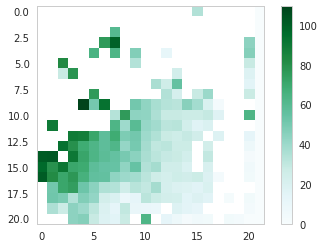

In [567]:
# trying out different color pallet
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots()
    im = ax.imshow(mapmatrix, cmap='BuGn')
    ax.grid(False)
    plt.colorbar(im)


In [101]:
# temp vs. vpd
temps = np.arange(df_summary.temp.min(), df_summary.temp.max(), 1)
vpds = np.arange(df_summary.vpd.max(), df_summary.vpd.min(), -0.15)
mapmatrix = np.zeros((len(temps), len(vpd)))
print(mapmatrix.shape)

for i in np.arange(len(temps)-1):
    df_t = df_summary[(df_summary.temp > temps[i]) & (df_summary.temp < temps[i+1])]
    
    for j in np.arange(len(vpd)-1):
        df_p = df_t[(df_t.vpd < vpds[j]) &  (df_t.vpd > vpds[j+1])]
        mapmatrix[j,i] = df_p.ear.mean()

fig, ax = plt.subplots()
im = ax.imshow(mapmatrix, cmap='YlGn')
ax.grid(False)
plt.colorbar(im)
ax.set_xticks(np.arange(0, len(temps), 5))
ax.set_yticks(np.arange(0, len(vpds), 3))
ax.set_xticklabels(np.round(temps,2)[np.arange(0, len(temps), 3)])
ax.set_yticklabels(np.round(vpds,2)[np.arange(0, len(vpds), 3)])
ax.set_xlabel('temperature (˚C)')
ax.set_ylabel('vpd (kPa)')

(21, 1561)


IndexError: index 22 is out of bounds for axis 0 with size 22

200220 notes:
- how this pattern might change
- 2

(22, 22)


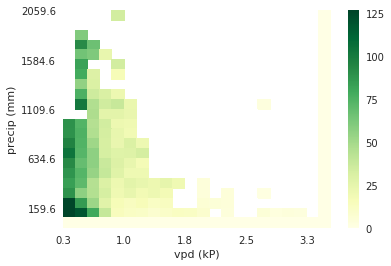

In [576]:
vpds = np.arange(df_summary.vpd.min(), df_summary.vpd.max(), 0.15)
precips = np.arange(df_summary.precip.max(), df_summary.precip.min(), -95)
mapmatrix = np.zeros((len(vpds), len(precips)))
print(mapmatrix.shape)

for i in np.arange(len(vpds)-1):
    df_t = df_summary[(df_summary.vpd > vpds[i]) & (df_summary.vpd < vpds[i+1])]
    
    for j in np.arange(len(precips)-1):
        df_p = df_t[(df_t.precip < precips[j]) &  (df_t.precip > precips[j+1])]
        mapmatrix[j,i] = df_p.ear.mean()

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots()
    ax = sns.heatmap(mapmatrix, cmap='YlGn')                                                      
    ax.set_xticks(np.arange(0, len(temps), 5))
    ax.set_yticks(np.arange(0, len(precips), 5))
    ax.set_xticklabels(np.round(vpds,1)[np.arange(0, len(vpds), 5)], rotation=0)
    ax.set_yticklabels(np.round(precips,1)[np.arange(0, len(precips), 5)], rotation=0)
    ax.set_xlabel('vpd (kP)')
    ax.set_ylabel('precip (mm)')

In [77]:
df_stats = pd.DataFrame(columns=['site', 'n', 'corr_temp', 'corr_rh', 'corr_precip'])

for i in sites:
    df_site = df_summary[df_summary.site == i]
    n = df_site.shape[0]
    corr_temp, _ = pearsonr(df_site.temp, df_site.ear)
    corr_rh, _ = pearsonr(df_site.rh, df_site.ear)
    corr_precip, _ = pearsonr(df_site.precip, df_site.ear)
    df_s = pd.DataFrame({'site': [i], 'n': [n], 
                         'corr_temp': [corr_temp], 
                         'corr_rh': [corr_rh], 
                         'corr_precip': [corr_precip]})
    df_stats = df_stats.append(df_s)

df_stats = pd.merge(df_stats, df_siteinfo, how='left', on='site')

/home/disk/eos8/ach315/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2998: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/disk/eos8/ach315/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/disk/eos8/ach315/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2999: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/home/disk/eos8/ach315/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/disk/eos8/ach315/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3013: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))


In [78]:
df_stats.head()

,site,n,corr_temp,corr_rh,corr_precip,city,state,lat,lon
0,03103,0,NaN,NaN,NaN,FLAGSTAFF,AZ,35.08,111.4
1,03812,8,-0.324470,0.921460,0.705476,ASHEVILLE,NC,35.26,82.32
2,03813,9,-0.041507,0.061338,-0.406711,MACON,GA,32.42,83.39
3,03820,9,-0.696990,0.480804,0.146330,AUGUSTA,GA,33.22,81.58
4,03822,15,-0.649239,0.408574,0.192777,SAVANNAH,GA,32.08,81.12


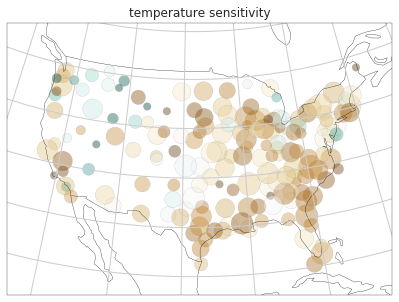

In [194]:
extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(7,5))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))

ax.scatter(df_stats.lon.astype(float)*-1, df_stats.lat.astype(float), 
           transform=ccrs.PlateCarree(), 
           c= df_stats.corr_temp, #s= df_stats.n,
           cmap="BrBG", alpha=0.4, edgecolors="grey", s=df_stats.n.astype(int)*30)

ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines()
ax.set_title('temperature sensitivity')

plt.show()

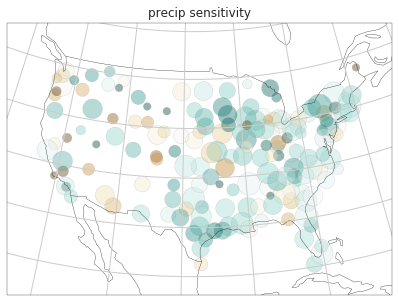

In [215]:
extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(7,5))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))

ax.scatter(df_stats.lon.astype(float)*-1, df_stats.lat.astype(float), 
           transform=ccrs.PlateCarree(), 
           c= df_stats.corr_precip, #s= df_stats.n,
           cmap="BrBG", alpha=0.4, edgecolors="grey", s=df_stats.n.astype(int)*30)

ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines()
ax.set_title('precip sensitivity')

plt.show()

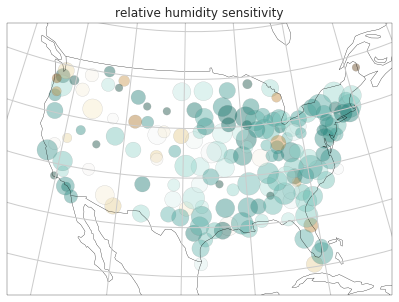

In [216]:
extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(7,5))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))

ax.scatter(df_stats.lon.astype(float)*-1, df_stats.lat.astype(float), 
           transform=ccrs.PlateCarree(), 
           c= df_stats.corr_rh, #s= df_stats.n,
           cmap='BrBG', alpha=0.4, edgecolors='grey', s=df_stats.n.astype(int)*30)

ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines()
ax.set_title('relative humidity sensitivity')


plt.show()

### 6. Plotting anomalies

I think you can get all the information you need with 'df_summary'

In [15]:
df_summary.head()

,ear,site,year,years,city,state,lat,lon,precip,temp,rh,vpd
3,99.10,03812,1975,20,ASHEVILLE,NC,35.26,82.32,1750.2,17.913493,80.071098,0.413221
4,97.84,03812,1979,20,ASHEVILLE,NC,35.26,82.32,791.1,18.049854,81.851357,0.379605
7,86.80,03812,1982,20,ASHEVILLE,NC,35.26,82.32,617.6,17.988220,80.312714,0.410168
8,70.20,03812,1983,20,ASHEVILLE,NC,35.26,82.32,628.7,18.176417,75.849098,0.509255
9,71.69,03812,1985,20,ASHEVILLE,NC,35.26,82.32,555.7,17.986991,76.229819,0.495193


In [101]:
df_summary['ear_diff'] = df_summary.ear - df_summary.groupby('site').transform('mean').ear
df_summary['temp_diff'] = df_summary.temp - df_summary.groupby('site').transform('mean').temp
df_summary['precip_diff'] = df_summary.precip - df_summary.groupby('site').transform('mean').precip
df_summary['rh_diff'] = df_summary.rh - df_summary.groupby('site').transform('mean').rh

In [102]:
df_summary.head()

,ear,site,year,years,city,state,lat,lon,precip,temp,rh,vpd,ear_diff,temp_diff,precip_diff,rh_diff
3,99.10,03812,1975,20,ASHEVILLE,NC,35.26,82.32,1750.2,17.913493,80.071098,0.413221,23.86,-0.052759,954.975,2.829528
4,97.84,03812,1979,20,ASHEVILLE,NC,35.26,82.32,791.1,18.049854,81.851357,0.379605,22.60,0.083602,-4.125,4.609788
7,86.80,03812,1982,20,ASHEVILLE,NC,35.26,82.32,617.6,17.988220,80.312714,0.410168,11.56,0.021968,-177.625,3.071144
8,70.20,03812,1983,20,ASHEVILLE,NC,35.26,82.32,628.7,18.176417,75.849098,0.509255,-5.04,0.210165,-166.525,-1.392471
9,71.69,03812,1985,20,ASHEVILLE,NC,35.26,82.32,555.7,17.986991,76.229819,0.495193,-3.55,0.020739,-239.525,-1.011751


#### - plotting anomalies on graphs

In [169]:
sns.set(style='whitegrid', palette='pastel')
sns.set_style({'axes.grid' : False})

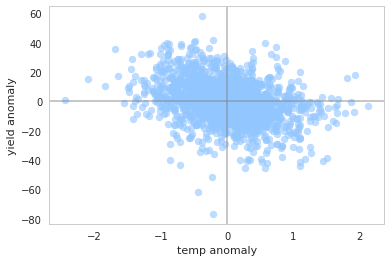

In [188]:
plt.scatter(df_summary.temp_diff, df_summary.ear_diff, alpha=0.6)
plt.xlabel('temp anomaly')
plt.ylabel('yield anomaly')
plt.axhline(y=0, c='grey', alpha=0.5)
plt.axvline(x=0, c='grey', alpha=0.5)

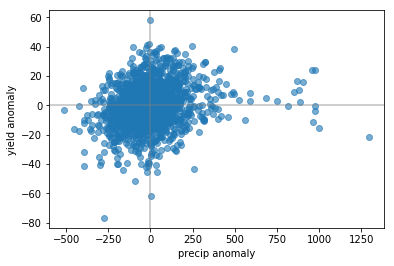

In [109]:
plt.scatter(df_summary.precip_diff, df_summary.ear_diff, alpha=0.6)
plt.xlabel('precip anomaly')
plt.ylabel('yield anomaly')
plt.axhline(y=0, c='grey', alpha=0.5)
plt.axvline(x=0, c='grey', alpha=0.5)

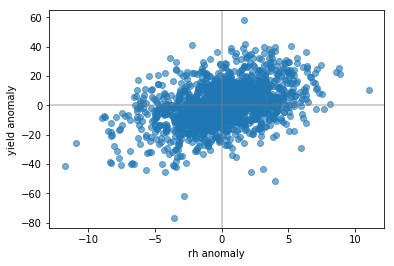

In [108]:
plt.scatter(df_summary.rh_diff, df_summary.ear_diff, alpha=0.6)
plt.xlabel('rh anomaly')
plt.ylabel('yield anomaly')
plt.axhline(y=0, c='grey', alpha=0.5)
plt.axvline(x=0, c='grey', alpha=0.5)

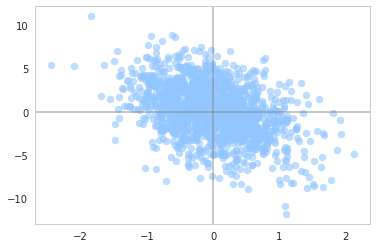

In [219]:
plt.scatter(df_summary.temp_diff, df_summary.rh_diff, alpha=0.6)
plt.axhline(y=0, c='grey', alpha=0.5)
plt.axvline(x=0, c='grey', alpha=0.5)

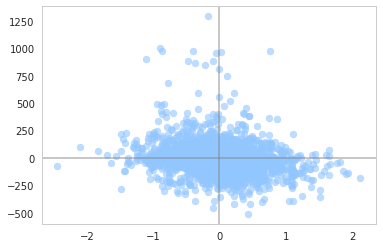

In [220]:
plt.scatter(df_summary.temp_diff, df_summary.precip_diff, alpha=0.6)
plt.axhline(y=0, c='grey', alpha=0.5)
plt.axvline(x=0, c='grey', alpha=0.5)

#### - plotting anomalies on maps

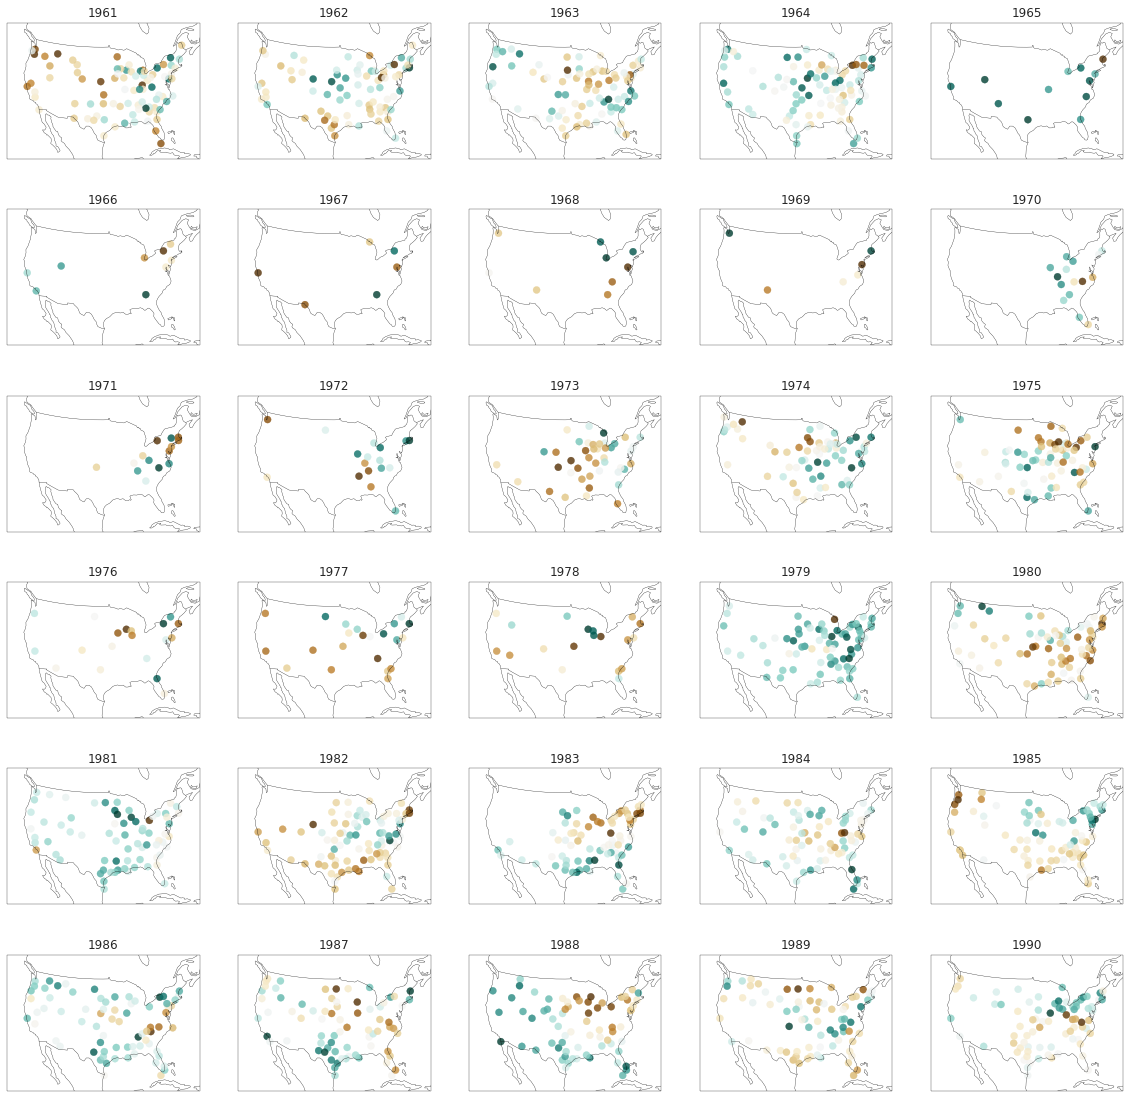

In [114]:
years = np.arange(1961, 1991)
extent = [-123, -72, 19, 53]

fig, axs = plt.subplots(6, 5, figsize=(20,20), 
                        subplot_kw={'projection': ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35)})

for ax, year in zip(axs.flatten(), years):
    df_sub = df_summary[df_summary.year == str(year)]
    ax.scatter(df_sub.lon.astype(float)*-1, df_sub.lat.astype(float), 
               c=df_sub.ear_diff, cmap='BrBG',
               transform=ccrs.PlateCarree(), alpha=0.8, s=50)

    ax.set_extent(extent)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.set(title=year)    

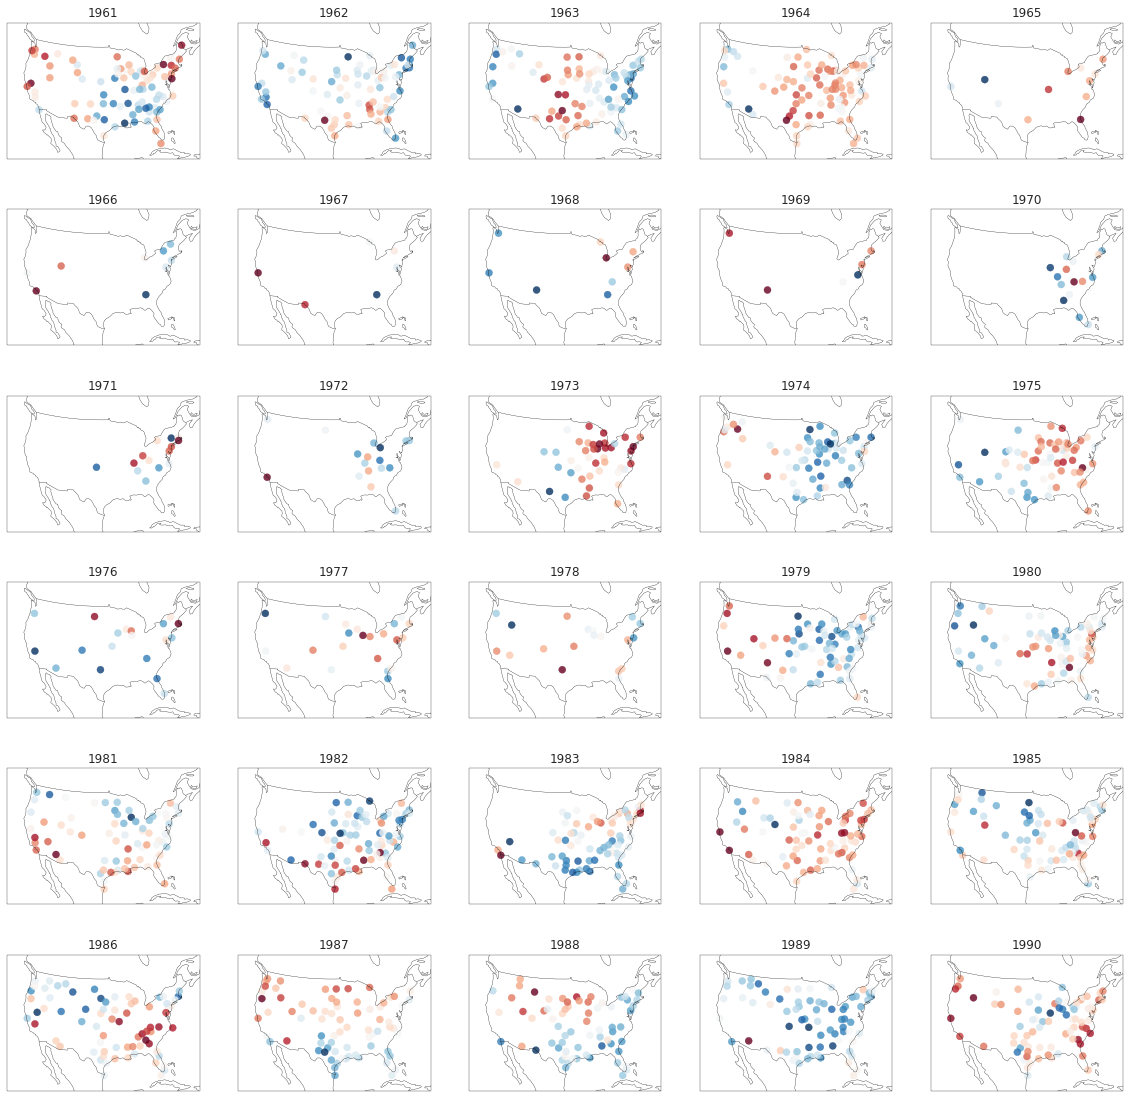

In [380]:
years = np.arange(1961, 1991)
extent = [-123, -72, 19, 53]

fig, axs = plt.subplots(6, 5, figsize=(20,20), 
                        subplot_kw={'projection': ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35)})

for ax, year in zip(axs.flatten(), years):
    df_sub = df_summary[df_summary.year == str(year)]
    ax.scatter(df_sub.lon.astype(float)*-1, df_sub.lat.astype(float), 
               c=df_sub.temp_diff, cmap='RdBu_r',
               transform=ccrs.PlateCarree(), alpha=0.8, s=50)

    ax.set_extent(extent)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.set(title=year)    

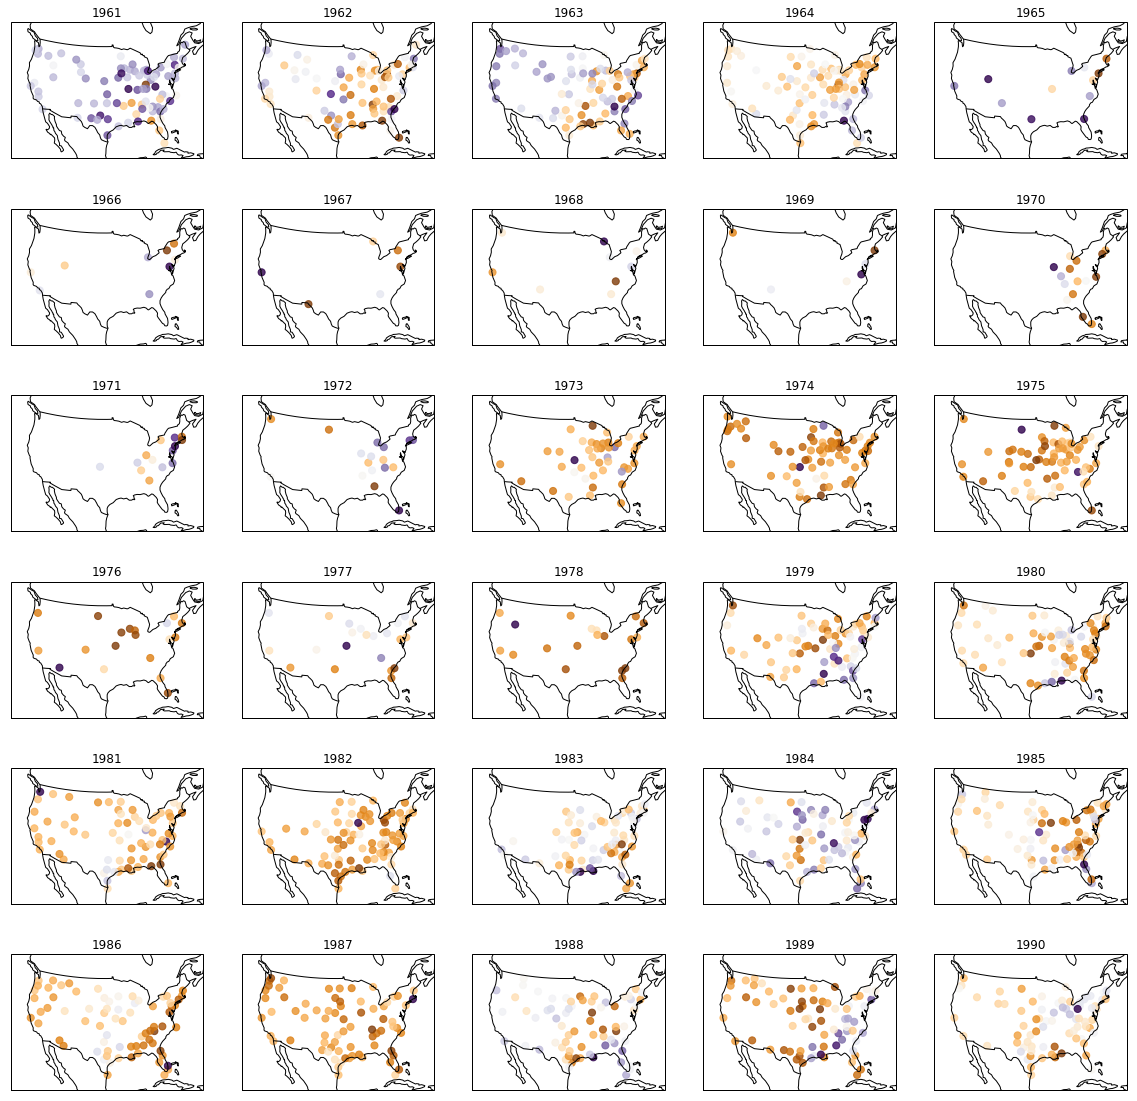

In [96]:
years = np.arange(1961, 1991)
extent = [-123, -72, 19, 53]

fig, axs = plt.subplots(6, 5, figsize=(20,20), 
                        subplot_kw={'projection': ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35)})

for ax, year in zip(axs.flatten(), years):
    df_sub = df_summary[df_summary.year == str(year)]
    ax.scatter(df_sub.lon.astype(float)*-1, df_sub.lat.astype(float), 
               c=df_sub.precip_diff, cmap='PuOr',
               transform=ccrs.PlateCarree(), alpha=0.8, s=50)

    ax.set_extent(extent)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.set(title=year)    

### Last thing to do - store notebook environment

In [14]:
import dill
dill.dump_session('sim_con_env.db')